In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Importing Libraries.
from datetime import datetime 
start_real = datetime.now()
import numpy as np
import pandas as pd
import math
import pickle
from nltk.corpus import stopwords
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import FeatureUnion

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dropout, Dense, concatenate
from keras.layers import GRU, Embedding, Flatten, Activation
from keras.models import Model

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from keras.layers import Input, Dense, Embedding, Dense, Dropout, Flatten, Conv1D, GlobalMaxPooling1D, BatchNormalization, LSTM, GRU
from keras.models import Model
from keras import optimizers

Using TensorFlow backend.


In [0]:
# Defining Utility Functions :

# 1. RMSLE Function 
def rmsle(y, y_pred): # return Rmsle value.
    return np.sqrt(np.mean(np.square(y_pred - y )))  
    
#------------------------------------------------------------------

# 2. Word Count Function.
def word_count(text):
    try:
        if text == 'No description yet':
            return 0 # for the data point with string "No description yet" returns word count 0.
        else:
            text = text.lower()
            words = []
            for w in text.split(" "):
              words.append(w)
            return len(words)
    except: 
        return 0

#------------------------------------------------------------------


# 3.Splitting category into sub categories.
def cat_split(column, sub_cat):
    category = []
    for i in range(len(train)):
        try:
            category.append(train[column].values[i].split("/")[sub_cat])
        except:
            category.append("No Label") # If there is no sub category it repalces No Label.
            
    return category

def cat_split_test(column, sub_cat):
    category = []
    for i in range(len(test)):
        try:
            category.append(test[column].values[i].split("/")[sub_cat])
        except:
            category.append("No Label") # If there is no sub category it repalces No Label.
    return category

#------------------------------------------------------------------


# 4. finding missing brands.
#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
# The Brand Name has 600,000 Missing Values. This Function will replace the data. 
def finding_brand(row_n):
    brand_row = row_n[0]
    name = row_n[1]
    namesplit = name.split(' ') # for missing brand we check every word in the name column
    if brand_row == 'missing':
        for x in namesplit: # Then we check for every word in brand vocabulary.if exists retur name
            if x in brand_vocab:
                return name 
    if name in brand_vocab:
        return name
    return brand_row

#------------------------------------------------------------------

# 5. Filling Missing values. Filling Columns names, category_name, item_description, brand_name 
def fill_missing_values(df):
    df.category_name.fillna(value="missing", inplace=True)
    df.brand_name.fillna(value="missing", inplace=True)
    df.item_description.fillna(value="missing", inplace=True)
    df.item_description.replace('No description yet',"missing", inplace=True)
    return df

# **Machine Learning Models**


In [0]:
# Import Train Data.
print("Importing Train Data:")
train = pd.read_table('/content/drive/My Drive/train.tsv')
print("Shape of Train Data:", train.shape)
print("Checking For NaN in the data...")
print(train.isnull().any())
print("Removing rows which has price value less than 5")
# Removing Lower Prices which are less than 5. As Majority of the prices range above 5
train = train.drop(train[(train.price < 5.0)].index)
print("Computing Word Count of item_description")
train['desc_len'] = train['item_description'].apply(lambda x: word_count(x))
print("Computing Word Count of name")
train['name_len'] = train['name'].apply(lambda x: word_count(x))
print("Splitting category_name to sub categories")
# Subdiving category.
train["subcat_0"] = cat_split("category_name",0)
train["subcat_1"] = cat_split("category_name",1)
train["subcat_2"] = cat_split("category_name",2)
print("Performing Feature Engineering and preprocessing :")
# Filling All the NAN rows of brand name with text "missing"
# Get all the vocabulary of all the words in the column Brand.
print("Filling Missing values in the Brand name...")
brand_vocab = set(train['brand_name'].values) # Get all the brands.
train.brand_name.fillna(value = "missing", inplace = True)
# Total Count with rows "missing"
missing = len(train.loc[train["brand_name"] == 'missing'])
print("Total Missing Values:", missing)
# Filling Missing values in the brand_name. 
train['brand_name'] = train[['brand_name','name']].apply(finding_brand, axis = 1) 
# Checking number of detected brand names from name column.
detected_brands = missing-len(train.loc[train['brand_name'] == 'missing'])
print("Total Detected brand names :",detected_brands)
train = fill_missing_values(train)
print(train.category_name[1])
print("Verifying Null Values in the data :", train.isnull().any())
print("Converting Columns to Strings : ")
# We Convert all the data columns in the form of strings.
train['category_name'] = train['category_name'].fillna('missing').astype(str)
train['subcat_0'] = train['subcat_0'].astype(str)
train['subcat_1'] = train['subcat_1'].astype(str)
train['subcat_2'] = train['subcat_2'].astype(str)
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['desc_len'] = train['desc_len'].astype(str)
train['name_len'] = train['name_len'].astype(str)
train['item_description'] = train['item_description'].fillna('No description yet').astype(str)
print("Natural Logarithm on Price...")
train["target"] = np.log1p(train.price)

Importing Train Data:
Shape of Train Data: (1482535, 8)
Checking For NaN in the data...
train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool
Removing rows which has price value less than 5
Computing Word Count of item_description
Computing Word Count of name
Splitting category_name to sub categories
Performing Feature Engineering and preprocessing :
Filling Missing values in the Brand name...
Total Missing Values: 607593
Total Detected brand names : 125239
Electronics/Computers & Tablets/Components & Parts
Verifying Null Values in the data : train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
desc_len             False
name_len             False
subcat_

In [0]:
# Train and Test Split:
x_train, x_test = train_test_split(train, random_state=123, train_size=0.99)
print(x_train.shape)
print(x_test.shape)
Y_train = x_train.target.values.reshape(-1, 1)
Y_test = x_test.target.values.reshape(-1,1)

(1432350, 14)
(14469, 14)


In [0]:
# Vectorizing Data.
# https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af
#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
# https://blog.usejournal.com/featureunion-a-time-saver-when-building-a-machine-learning-model-d0ad7a90f215

default_preprocessor = CountVectorizer().build_preprocessor() # a callable function that preprocesses the text data.

def build_preprocessor(colum, ):
  # We are preprocessing each columns
    column_index = list(train.columns).index(colum) # Returns the Index of a specific Column.
    return lambda x: default_preprocessor(x[column_index])

# stack tfidf and count vectorize for all the columns.
vectorizer = FeatureUnion([
    ('name', CountVectorizer(ngram_range=(1, 3),max_features=10000,preprocessor = build_preprocessor('name'))),

    ('subcat_0', CountVectorizer(token_pattern = '.+',preprocessor = build_preprocessor('subcat_0'))),

    ('subcat_1', CountVectorizer(token_pattern = '.+',preprocessor = build_preprocessor('subcat_1'))),

    ('subcat_2', CountVectorizer(token_pattern = '.+',preprocessor = build_preprocessor('subcat_2'))),

    ('brand_name', CountVectorizer(token_pattern ='.+',preprocessor = build_preprocessor('brand_name'))),

    ('shipping', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('shipping'))),

    ('item_condition_id', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('item_condition_id'))),

    ('desc_len', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('desc_len'))),

    ('name_len', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('name_len'))),

    ('item_description', TfidfVectorizer(ngram_range = (1, 3),max_features = 100000,preprocessor = build_preprocessor('item_description'))),
])

In [0]:
# Fitting Vectorizer.
vectorizer.fit(x_train.values)
# Transforming Train and Test.
x = vectorizer.transform(x_train.values)
x_t = vectorizer.transform(x_test.values)
print(x.shape,x_t.shape)
X_train = x
X_test = x_t

(1432350, 222408) (14469, 222408)


**SVR**

In [0]:
# SVR 
Y_train = np.ravel(Y_train)
from sklearn.svm import SVR
params = [0.0001,0.001,0.01,0.1]
for i in params:
    
    svr = SVR(C = i, epsilon = 0.01)
    svr.fit(X_train, Y_train)
    y_pred = svr.predict(X_test)
    svr_rmsle = np.sqrt(mean_squared_error(Y_test, y_pred))
    print(i)
    print(svr_rmsle)

0.0001
0.5990894557275435
0.001
0.5868092755412005
0.01
0.5404932373507542
0.1
0.4755534110778424


**DecisionTreeReg**

In [0]:
from sklearn.tree import DecisionTreeRegressor

parameters = [(2,2),(4,5), (6,6),(9,8), ]

for i,j in tqdm(parameters):
    dt_reg = DecisionTreeRegressor(max_depth = i, min_samples_split = j)
    dt_reg.fit(X_train, Y_train)
    
    y_pred = dt_reg.predict(X_test)
    # Calculating RMSLE
    dt_rmsle = np.sqrt(mean_squared_error(Y_test, y_pred))
    print("For Depth:",i)
    print("For Min_sample_split : ", j)
    print("RMSLE : ", dt_rmsle)
    

 25%|██▌       | 1/4 [00:54<02:43, 54.47s/it]

For Depth: 2
For Min_sample_split :  2
RMSLE :  0.7092153254274274


 50%|█████     | 2/4 [02:35<02:16, 68.37s/it]

For Depth: 4
For Min_sample_split :  5
RMSLE :  0.6802232886209346


 75%|███████▌  | 3/4 [05:20<01:37, 97.37s/it]

For Depth: 6
For Min_sample_split :  6
RMSLE :  0.6628085974892538


100%|██████████| 4/4 [10:54<00:00, 163.70s/it]

For Depth: 9
For Min_sample_split :  8
RMSLE :  0.6353326424231599


In [0]:
from sklearn.tree import DecisionTreeRegressor

parameters = [(10,15),(15,20), (30,50),(50,100), ]

for i,j in tqdm(parameters):
    dt_reg = DecisionTreeRegressor(max_depth = i, min_samples_split = j)
    dt_reg.fit(X_train, Y_train)
    
    y_pred = dt_reg.predict(X_test)
    # Calculating RMSLE
    dt_rmsle = np.sqrt(mean_squared_error(Y_test, y_pred))
    print("For Depth:",i)
    print("For Min_sample_split : ", j)
    print("RMSLE : ", dt_rmsle)
    

 25%|██▌       | 1/4 [06:50<20:32, 410.86s/it]

For Depth: 10
For Min_sample_split :  15
RMSLE :  0.6292677048629349


 50%|█████     | 2/4 [24:15<20:02, 601.11s/it]

For Depth: 15
For Min_sample_split :  20
RMSLE :  0.6048510105794948


 75%|███████▌  | 3/4 [1:31:31<27:11, 1631.60s/it]

For Depth: 30
For Min_sample_split :  50
RMSLE :  0.5672880245885058


max_depth = 30, min Sample Split = 50

**SgdReg**

In [0]:
from sklearn.linear_model import SGDRegressor
Y_train = np.ravel(Y_train)

parameters = [0.00001, 0.0001,0.001,0.01,0.1,0,1,10]

for i in parameters:
    sgd_reg = SGDRegressor(alpha = i, loss = 'squared_loss', penalty = 'l2', learning_rate = 'constant')
    sgd_reg.fit(X_train, Y_train)
    y_pred = sgd_reg.predict(X_test)
    y_pred =  y_pred.reshape(-1, 1)
    sgd_rmsle = np.sqrt(mean_squared_error(Y_test, y_pred))
    print("For Alpha:",i)
    print("RMSLE ridgecv:", sgd_rmsle)

For Alpha: 1e-05
RMSLE ridgecv: 0.45376929969734825
For Alpha: 0.0001
RMSLE ridgecv: 0.4760848688908972
For Alpha: 0.001
RMSLE ridgecv: 0.5297605865265459
For Alpha: 0.01
RMSLE ridgecv: 0.5980632891841436
For Alpha: 0.1
RMSLE ridgecv: 0.669138478237479
For Alpha: 0
RMSLE ridgecv: 0.45449834341396417
For Alpha: 1
RMSLE ridgecv: 0.72085375442452
For Alpha: 10
RMSLE ridgecv: 0.7359748471151365


alpha = 0.00001

**RidgeReg**

In [0]:
# Ridge Regression.
ridge_reg = Ridge(solver='auto', fit_intercept=True, alpha=1.0,max_iter=100, normalize=False, tol=0.05, random_state = 1,)
ridge_reg.fit(X_train, Y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100, normalize=False,
      random_state=1, solver='auto', tol=0.05)

In [0]:
y_pred = ridge_reg.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
print("RMSLE Ridge:", rmsle(Y_test, y_pred))

RMSLE Ridge: 0.47499265313099626


In [0]:
ridge_cv = RidgeCV(alphas=[10.0], fit_intercept= True,normalize=False, cv = 3, scoring='neg_mean_squared_error',)
ridge_cv.fit(X_train, Y_train)
y_pred = ridge_cv.predict(X_test)
y_pred = y_pred.reshape(-1, 1)
print("RMSLE ridgecv:", rmsle(Y_test, y_pred))

RMSLE ridgecv: 0.4432021951114149


**Ensembles**

In [0]:
# SVR, RIDGE, SGD.
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import VotingRegressor

model_1 = SVR(C = 0.1, epsilon = 0.01)
model_2 = RidgeCV(fit_intercept=True, alphas=[10.0],normalize=False, cv = 3, scoring='neg_mean_squared_error',)
model_3 = SGDRegressor(alpha = 0.00001, loss = 'squared_loss', penalty = 'l2', learning_rate = 'constant')

reg = VotingRegressor([("svr", model_1), ("r", model_2), ("sgd", model_3)], n_jobs = -1)
reg.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_voting.py:406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingRegressor(estimators=[('svr',
                             SVR(C=0.1, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.01, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False)),
                            ('r',
                             RidgeCV(alphas=array([5.]), cv=2,
                                     fit_intercept=True, gcv_mode=None,
                                     normalize=False,
                                     scoring='neg_mean_squared_error',
                                     store_cv_values=False)),
                            ('sgd',
                             SGDRegressor(alpha=1e-05, average=False,
                                          early_stopping=False, epsilon=0.1,
                                          eta0=0.01, fit_intercept=True,
                                          l1_ratio=0.15,
                   

In [0]:
y_pred = reg.predict(X_test)
y_pred = y_pred.reshape(-1,1)
print("Ensemble Rmsle error:", rmsle(Y_test, y_pred))

Ensemble Rmsle error: 0.4451476373350806


### PrettyTable.

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Alpha", "Rmsle Error"]
x.add_row(["SVR", 0.1, 0.47])
x.add_row(["Decision Tree Reg", 30, 0.56])
x.add_row(["RidgeReg Cv",5, 0.44])
x.add_row(["SGD Reg", 0.00001, 0.45])
x.add_row(["RRidgeReg",1,  0.48])
x.add_row(["Ensemble Voting Reg", "sgd, Rf, svr", 0.44])
print(x)

+---------------------+--------------+-------------+
|        Model        |    Alpha     | Rmsle Error |
+---------------------+--------------+-------------+
|         SVR         |     0.1      |     0.47    |
|  Decision Tree Reg  |      30      |     0.56    |
|     RidgeReg Cv     |      5       |     0.44    |
|       SGD Reg       |    1e-05     |     0.45    |
|      RRidgeReg      |      1       |     0.48    |
| Ensemble Voting Reg | sgd, Rf, svr |     0.44    |
+---------------------+--------------+-------------+


Ensemble Performed Well with rmsle score of 0.44, and also ridge cv scored good with 0.44

# **Implementing Deep learning Models.**

In [0]:
# Importing train data.
print("Importing Train Data...")
train = pd.read_table('/content/drive/My Drive/train.tsv')
print("Shape of Train data :",train.shape)
# Checking for NaN in the data.
print("Checking for any null values..")
print(train.isnull().any())
print("Performing Preprocessing and Feature engineering...")
# Removing Lower Prices which are less than 3.
train = train.drop(train[(train.price < 5.0)].index)
train.shape
# Getting Length of each text in name and item_description.
train['desc_len'] = train['item_description'].apply(lambda x: word_count(x))
train['name_len'] = train['name'].apply(lambda x: word_count(x))
train.head()
# Subdiving category.
train["subcat_0"] = cat_split("category_name",0)
train["subcat_1"] = cat_split("category_name",1)
train["subcat_2"] = cat_split("category_name",2)
# Filling All the NAN rows of brand name with text "missing"
brand_vocab = set(train['brand_name'].values) # Get all the brands.
train.brand_name.fillna(value = "missing", inplace = True)
#all_brands
missing = len(train.loc[train["brand_name"] == 'missing'])
#premissing
print(missing)
train['brand_name'] = train[['brand_name','name']].apply(finding_brand, axis = 1)
detected_brands = missing-len(train.loc[train['brand_name'] == 'missing'])
print(detected_brands)
train = fill_missing_values(train)
print(train.category_name[1])
train["target"] = np.log1p(train.price)

Importing Train Data...
Shape of Train data : (1482535, 8)
Checking for any null values..
train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool
Performing Preprocessing and Feature engineering...
607593
125239
Electronics/Computers & Tablets/Components & Parts


In [0]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [0]:
# Encoding Categorical Features.
label = LabelEncoderExt()
label.fit(train.category_name) # categories united 
train['category'] = label.transform(train.category_name)

label.fit(train.brand_name) # brand name 
train.brand_name = label.transform(train.brand_name)

label.fit(train.subcat_0) # sub_cat0
train.subcat_0 = label.transform(train.subcat_0)

label.fit(train.subcat_1) # sub_cat_1
train.subcat_1 = label.transform(train.subcat_1)

label.fit(train.subcat_2) # sub_cat2
train.subcat_2 = label.transform(train.subcat_2)

del label

In [0]:
# Text to Sequence Data.
# Combining columns, item_description, name, category_name.
full_text = np.hstack([train.item_description.str.lower(), train.name.str.lower(), train.category_name.str.lower()]) 

# Tokenizing on combined columns.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_text)
 
train['seq_desc'] = tokenizer.texts_to_sequences(train.item_description.str.lower()) 
train['seq_name'] = tokenizer.texts_to_sequences(train.name.str.lower()) 

In [0]:
# finding out max len of all the text data combined.
max_len = np.max([np.max(train.seq_name.max()),np.max(train.seq_desc.max()),])
# max length for Categorical Data.
#max_len_cat = np.max(train.category.max()) + 1 # category
max_len_brand = np.max(train.brand_name.max())    # brand 
max_len_condition = np.max(int(max(train.item_condition_id)))  # item_cond
max_len_desc = np.max(int(train.desc_len.max()))  # item_desc_len
max_len_name = np.max(int(train.name_len.max()))  # name_len
max_len_sub0 = np.max(int(train.subcat_0.max()))  # Sub_0
max_len_sub1 = np.max(int(train.subcat_1.max()))  # Sub_1
max_len_sub2 = np.max(train.subcat_2.max())  # Sub_2
# Defining max length for Padding Text Data.
name_padding = 15
description_padding = 80

In [0]:
# Train and Test Split.
x_tr, x_te = train_test_split(train, random_state=123, train_size=0.99)
Y_train = x_tr.target.values.reshape(-1, 1)
Y_test = x_te.target.values.reshape(-1, 1)

In [0]:
# Padding Name :
x_train_padded = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_tr.brand_name),
"category" :np.array(x_tr.category),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.subcat_0),
"subcat_1"  : np.array(x_tr.subcat_1),
"subcat_2" : np.array(x_tr.subcat_2),
} 
x_test_padded = {
"name" : pad_sequences(x_te.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_te.brand_name),
"category" : np.array(x_te.category),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.subcat_0),
"subcat_1" : np.array(x_te.subcat_1),
"subcat_2" : np.array(x_te.subcat_2),
}

In [0]:
x_tr = x_train_padded
x_te = x_test_padded

In [0]:
# defining Model :
# inputs 
from keras.layers import LSTM, GRU
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import concatenate, BatchNormalization
from keras import optimizers

name = Input(shape=[x_tr["name"].shape[1]], name="name")
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc")
brand_name =Input(shape=[1], name="brand_name")
item_condition =Input(shape=[1], name="item_condition")
num_vars = Input(shape=[x_tr["shipping"].shape[1]], name="shipping")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
# Embedding Layers
name_emb = Embedding(max_len, 15)(name)
item_desc_emb = Embedding(max_len, 80)(item_desc)
brand_emb = Embedding(max_len_brand, 10)(brand_name)
item_cond_emb = Embedding(max_len_condition, 5)(item_condition)
desc_len_emb = Embedding(max_len_desc, 5)(desc_len)
name_len_emb = Embedding(max_len_name, 5)(name_len)
sub0_emb = Embedding(max_len_sub0, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2, 10)(subcat_2)

lstm_layer1 = GRU(16) (item_desc_emb)
lstm_layer2 = LSTM(8) (name_emb)
#Flattening
flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_3 = Flatten() (desc_len_emb)
flat_4 = Flatten() (name_len_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

# Concat
main_l = concatenate([flat_1,flat_2,flat_3,flat_4,flat_5,flat_6,flat_7,lstm_layer1,lstm_layer2, num_vars])
#Dense Layers
main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))
#Compile
output = Dense(1, activation="linear") (main_l)
model_2 = Model([name, item_desc, brand_name , item_condition, num_vars, desc_len, name_len, subcat_0, subcat_1, subcat_2], output)
optimizer = optimizers.Adam(lr= 0.005)
model_2.compile(loss = 'mse', optimizer = optimizer)
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
desc_len (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
name_len (InputLayer)           (None, 1)            0                                            
____________________________________________________________________________________________

In [0]:
epochs = 3
# Create model and fit it with training dataset.
model_2.fit(x_tr, Y_train, epochs = epochs, batch_size = 512 * 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3
1432350/1432350 [==============================] - 168s 117us/step - loss: 0.4629
Epoch 2/3
1432350/1432350 [==============================] - 164s 115us/step - loss: 0.1556
Epoch 3/3
1432350/1432350 [==============================] - 164s 114us/step - loss: 0.1291


In [0]:
y_pred = model_2.predict(x_te, batch_size=batch_size)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.4249679056655569


# **Experimenting With Cnn's**


In [0]:
# Importing train data.
print("Importing Train Data...")
train = pd.read_table('/content/drive/My Drive/train.tsv')
print("Shape of Train data :",train.shape)
# Checking for NaN in the data.
print("Checking for any null values..")
print(train.isnull().any())
print("Performing Preprocessing and Feature engineering...")
# Removing Lower Prices which are less than 5.
train = train.drop(train[(train.price < 5.0)].index)
train.shape
# Getting Length of each text in name and item_description.
train['desc_len'] = train['item_description'].apply(lambda x: word_count(x))
train['name_len'] = train['name'].apply(lambda x: word_count(x))
train.head()
# Subdiving category.
train["subcat_0"] = cat_split("category_name",0)
train["subcat_1"] = cat_split("category_name",1)
train["subcat_2"] = cat_split("category_name",2)
# Filling All the NAN rows of brand name with text "missing"
brand_vocab = set(train['brand_name'].values) # Get all the brands.
train.brand_name.fillna(value = "missing", inplace = True)
#all_brands
missing = len(train.loc[train["brand_name"] == 'missing'])
#premissing
print(missing)
train['brand_name'] = train[['brand_name','name']].apply(finding_brand, axis = 1)
detected_brands = missing-len(train.loc[train['brand_name'] == 'missing'])
print(detected_brands)
train = fill_missing_values(train)
print(train.category_name[1])
train["target"] = np.log1p(train.price)

Importing Train Data...
Shape of Train data : (1482535, 8)
Checking for any null values..
train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool
Performing Preprocessing and Feature engineering...
607593
125239
Electronics/Computers & Tablets/Components & Parts


In [0]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [0]:
# Encoding Categorical Features.
label = LabelEncoderExt()
label.fit(train.category_name) # categories united 
train['category'] = label.transform(train.category_name)

label.fit(train.brand_name) # brand name 
train.brand_name = label.transform(train.brand_name)

label.fit(train.subcat_0) # sub_cat0
train.subcat_0 = label.transform(train.subcat_0)

label.fit(train.subcat_1) # sub_cat_1
train.subcat_1 = label.transform(train.subcat_1)

label.fit(train.subcat_2) # sub_cat2
train.subcat_2 = label.transform(train.subcat_2)

del label

In [0]:
# Text to Sequence Data.
# Combining columns, item_description, name, category_name.
full_text = np.hstack([train.item_description.str.lower(), train.name.str.lower(), train.category_name.str.lower()]) 

# Tokenizing on combined columns.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_text)
 
train['seq_desc'] = tokenizer.texts_to_sequences(train.item_description.str.lower()) 
train['seq_name'] = tokenizer.texts_to_sequences(train.name.str.lower()) 

In [0]:
max_len_brand = np.max(train.brand_name.max())    # brand 
max_len_condition = np.max(int(max(train.item_condition_id)))  # item_cond
max_len_desc = np.max(int(train.desc_len.max()))  # item_desc_len
max_len_name = np.max(int(train.name_len.max()))  # name_len
max_len_sub0 = np.max(int(train.subcat_0.max()))  # Sub_0
max_len_sub1 = np.max(int(train.subcat_1.max()))  # Sub_1
max_len_sub2 = np.max(train.subcat_2.max())  # Sub_2
# Defining max length for Padding Text Data.
name_padding = 15
description_padding = 80
max_len = np.max([np.max(train.seq_name.max()),np.max(train.seq_desc.max()),])

In [0]:
# Train and Test Split.
x_tr, x_te = train_test_split(train, random_state=123, train_size=0.99)
Y_train = x_tr.target.values.reshape(-1, 1)
Y_test = x_te.target.values.reshape(-1, 1)

In [0]:
# Padding Name :
x_train_padded = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_tr.brand_name),
"category" :np.array(x_tr.category),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.subcat_0),
"subcat_1"  : np.array(x_tr.subcat_1),
"subcat_2" : np.array(x_tr.subcat_2),
} 
x_test_padded = {
"name" : pad_sequences(x_te.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_te.brand_name),
"category" : np.array(x_te.category),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.subcat_0),
"subcat_1" : np.array(x_te.subcat_1),
"subcat_2" : np.array(x_te.subcat_2),
}

In [0]:
x_tr = x_train_padded
x_te = x_test_padded

In [0]:
batch_size = 512 * 3
epochs = 2
exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(x_tr['name']) / batch_size) * epochs
lr_init, lr_fin = 0.005, 0.001
lr_decay = exp_decay(lr_init, lr_fin, steps)

In [0]:
len(x_tr['name'])/batch_size* 2

1865.0390625

In [0]:
lr_decay

0.0008642690853521984

In [0]:
# Definign Inputs.
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name = Input(shape=[1], name="brand_name")

num_vars = Input(shape=[x_tr["shipping"].shape[1]], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(shape=[x_tr["name"].shape[1]], name="name") # 15 shape = [15]
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc") # 80 shape = [80]

In [0]:
sub0_emb = Embedding(max_len_sub0, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2, 10)(subcat_2)

brand_emb = Embedding(max_len_brand, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition, 5)(item_condition)

name_emb = Embedding(max_len, 15)(name)
item_desc_emb = Embedding(max_len, 80)(item_desc)

desc_len_emb = Embedding(max_len_desc, 5)(desc_len)
name_len_emb = Embedding(max_len_name, 5)(name_len)


In [0]:
convs1 = []
convs2 = []
for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

In [0]:
convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

In [0]:
flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

In [0]:
main_l = concatenate([flat_1,flat_2,flat_5,flat_6,flat_7,convs1,convs2, num_vars ])

In [0]:
main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))

In [0]:
output = Dense(1, activation="linear") (main_l)
    
model_2 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, subcat_0, subcat_1, subcat_2, num_vars ], output)

optimizer = optimizers.Adam(lr = 0.005)
model_2.compile(loss = 'mse', optimizer = optimizer)

model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               (None, 15)           0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 15, 15)       3831630     name[0][0]                       
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 80, 80)       20435360    item_desc[0][0]                  
____________________________________________________________________________________________

In [0]:
model_2.fit(x_tr, Y_train, epochs= 2 , batch_size= 512 * 3)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
1432350/1432350 [==============================] - 80s 56us/step - loss: 0.4585
Epoch 2/2
1432350/1432350 [==============================] - 73s 51us/step - loss: 0.1629


In [0]:
y_pred = model_2.predict(x_te, batch_size=batch_size)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.42633457644517353


# **TESTING ON TEST DATA:**

In [0]:
# Importing train data.
print("Importing Train Data...")
train = pd.read_table('/content/drive/My Drive/train.tsv')
print("Shape of Train data :",train.shape)
# Checking for NaN in the data.
print("Checking for any null values..")
print(train.isnull().any())
print("Performing Preprocessing and Feature engineering...")
# Removing Lower Prices which are less than 3.
train = train.drop(train[(train.price < 5.0)].index)
train.shape
# Getting Length of each text in name and item_description.
train['desc_len'] = train['item_description'].apply(lambda x: word_count(x))
train['name_len'] = train['name'].apply(lambda x: word_count(x))
train.head()
# Subdiving category.
train["subcat_0"] = cat_split("category_name",0)
train["subcat_1"] = cat_split("category_name",1)
train["subcat_2"] = cat_split("category_name",2)
# Filling All the NAN rows of brand name with text "missing"
brand_vocab = set(train['brand_name'].values) # Get all the brands.
train.brand_name.fillna(value = "missing", inplace = True)
#all_brands
missing = len(train.loc[train["brand_name"] == 'missing'])
#premissing
print(missing)
train['brand_name'] = train[['brand_name','name']].apply(finding_brand, axis = 1)
detected_brands = missing-len(train.loc[train['brand_name'] == 'missing'])
print(detected_brands)
train = fill_missing_values(train)
print(train.category_name[1])
train["target"] = np.log1p(train.price)

Importing Train Data...
Shape of Train data : (1482535, 8)
Checking for any null values..
train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool
Performing Preprocessing and Feature engineering...
607593
125239
Electronics/Computers & Tablets/Components & Parts


In [0]:
# Importing Test data.
print("Importing Test Data...")
test = pd.read_table('/content/drive/My Drive/test.tsv')
print("Shape of Train data :",test.shape)
# Checking for NaN in the data.
print("Checking for any null values..")
print(test.isnull().any())
print("Performing Preprocessing and Feature engineering...")
# Removing Lower Prices which are less than 3.
test.shape
# Getting Length of each text in name and item_description.
test['desc_len'] = test['item_description'].apply(lambda x: word_count(x))
test['name_len'] = test['name'].apply(lambda x: word_count(x))
test.head()
# Subdiving category.
test["subcat_0"] = cat_split_test("category_name",0)
test["subcat_1"] = cat_split_test("category_name",1)
test["subcat_2"] = cat_split_test("category_name",2)
# Filling All the NAN rows of brand name with text "missing"
brand_vocab = set(test['brand_name'].values) # Get all the brands.
test.brand_name.fillna(value = "missing", inplace = True)
#all_brands
missing = len(test.loc[test["brand_name"] == 'missing'])
#premissing
print(missing)
test['brand_name'] = test[['brand_name','name']].apply(finding_brand, axis = 1)
detected_brands = missing-len(test.loc[test['brand_name'] == 'missing'])
print(detected_brands)
test = fill_missing_values(test)
print(test.category_name[1])

Importing Test Data...
Shape of Train data : (693359, 7)
Checking for any null values..
test_id              False
name                 False
item_condition_id    False
category_name         True
brand_name            True
shipping             False
item_description     False
dtype: bool
Performing Preprocessing and Feature engineering...
295525
59695
Other/Office supplies/Shipping Supplies


In [0]:
# https://stackoverflow.com/a/56876351
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [0]:
# We Convert all the data columns in the form of strings.
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
test['brand_name'] = test['brand_name'].fillna('missing').astype(str)


label = LabelEncoderExt()
label.fit(np.hstack([train.brand_name, test.brand_name]))
train['brand_name'] = label.transform(train.brand_name)
test['brand_name'] = label.transform(test.brand_name)
del label 

In [0]:
# Encoding Categorical Features.
label = LabelEncoderExt()
label.fit(np.hstack([train.category_name, test.category_name])) # categories united 

train['category'] = label.transform(train.category_name)
test['category'] = label.transform(test.category_name)

label.fit(np.hstack([train.subcat_0, test.subcat_0])) # sub_cat0
train.subcat_0 = label.transform(train.subcat_0)
test.subcat_0 = label.transform(test.subcat_0)

label.fit(np.hstack([train.subcat_1, test.subcat_1])) # sub_cat_1
train.subcat_1 = label.transform(train.subcat_1)
test.subcat_1 = label.transform(test.subcat_1)

label.fit(np.hstack([train.subcat_2, test.subcat_2])) # sub_cat2
train.subcat_2 = label.transform(train.subcat_2)
test.subcat_2 = label.transform(test.subcat_2)
del label 

In [0]:
# Text to Sequence Data.
# Combining columns, item_description, name, category_name.
full_text = np.hstack([train.item_description.str.lower(), train.name.str.lower(), train.category_name.str.lower()]) 

# Tokenizing on combined columns.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_text)
 
train['seq_desc'] = tokenizer.texts_to_sequences(train.item_description.str.lower()) 
test['seq_desc'] = tokenizer.texts_to_sequences(test.item_description.str.lower()) 

train['seq_name'] = tokenizer.texts_to_sequences(train.name.str.lower()) 
test['seq_name'] = tokenizer.texts_to_sequences(test.name.str.lower()) 

In [0]:
# max length for Categorical Data.
max_len_brand =  np.max([train.brand_name.max(), test.brand_name.max()])  # brand # brand 
max_len_condition = np.max([max(train.item_condition_id), max(test.item_condition_id)])  # item_cond
max_len_desc = np.max([int(train.desc_len.max()), int(test.desc_len.max())])  # item_desc_len
max_len_name = np.max([int(train.name_len.max()), int(test.name_len.max())])  # name_len
max_len_sub0 = np.max([int(train.subcat_0.max()), int(train.subcat_0.max())])  # Sub_0
max_len_sub1 = np.max([int(train.subcat_1.max()), int(train.subcat_1.max())])  # Sub_1
max_len_sub2 = np.max([train.subcat_2.max(), train.subcat_2.max()])  # Sub_2
# Defining max length for Padding Text Data.
name_padding = 15
description_padding = 80
max_len = np.max([np.max(train.seq_name.max()),np.max(train.seq_desc.max()),np.max(test.seq_name.max()),np.max(test.seq_desc.max())])

In [0]:
# Train and Test Split.
x_tr, x_te = train_test_split(train, random_state=123, train_size=0.99)
Y_train = x_tr.target.values.reshape(-1, 1)
Y_test = x_te.target.values.reshape(-1, 1)

In [0]:
# Padding Name :
x_train_padded = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_tr.brand_name),
"category" :np.array(x_tr.category),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.subcat_0),
"subcat_1"  : np.array(x_tr.subcat_1),
"subcat_2" : np.array(x_tr.subcat_2),
} 

x_test_padded = {
"name" : pad_sequences(x_te.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_te.brand_name),
"category" : np.array(x_te.category),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.subcat_0),
"subcat_1" : np.array(x_te.subcat_1),
"subcat_2" : np.array(x_te.subcat_2),
}


te_data = {
"name" : pad_sequences(test.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(test.seq_desc, maxlen= description_padding),
"brand_name" : np.array(test.brand_name),
"category" : np.array(test.category),
"item_condition" : np.array(test.item_condition_id),
"shipping" : np.array(test[["shipping"]]),
"desc_len" : np.array(test[["desc_len"]]),
"name_len" : np.array(test[["name_len"]]),
"subcat_0" : np.array(test.subcat_0),
"subcat_1" : np.array(test.subcat_1),
"subcat_2" : np.array(test.subcat_2),
}

In [0]:
x_tr = x_train_padded
x_te = x_test_padded
X_test = te_data

In [0]:
# Definign Inputs.
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name =Input(shape=[1], name="brand_name")

num_vars = Input(shape=[x_tr["shipping"].shape[1]], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(shape=[x_tr["name"].shape[1]], name="name") # 15 shape = [15]
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc") # 80 shape = [80]

sub0_emb = Embedding(max_len_sub0, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2, 10)(subcat_2)

brand_emb = Embedding(max_len_brand, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition, 5)(item_condition)

name_emb = Embedding(max_len, 15)(name)
item_desc_emb = Embedding(max_len, 80)(item_desc)

desc_len_emb = Embedding(max_len_desc, 5)(desc_len)
name_len_emb = Embedding(max_len_name, 5)(name_len)



convs1 = []
convs2 = []
for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

main_l = concatenate([flat_1,flat_2,flat_5,flat_6,flat_7,convs1,convs2, num_vars ])

main_l = Dropout(0.1)(Dense(256,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))


output = Dense(1, activation="linear") (main_l)
    
model_2 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, subcat_0, subcat_1, subcat_2, num_vars ], output)

optimizer = optimizers.Adam(lr = 0.005 )
model_2.compile(loss = 'mse', optimizer = optimizer)

model_2.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               (None, 15)           0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 80)           0                                            
__________________________________________________________________________________________________
embedding_71 (Embedding)        (None, 15, 15)       3831630     name[0][0]                       
__________________________________________________________________________________________________
embedding_72 (Embedding)        (None, 80, 80)       20435360    item_desc[0][0]                  
____________________________________________________________________________________________

In [0]:
# Create model and fit it with training dataset.
model_2.fit(x_tr, Y_train, epochs= 2 , batch_size= 512 * 3, validation_data = (x_te, Y_test), verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1432350 samples, validate on 14469 samples
Epoch 1/2
1432350/1432350 [==============================] - 76s 53us/step - loss: 0.4525 - val_loss: 0.1941
Epoch 2/2
1432350/1432350 [==============================] - 73s 51us/step - loss: 0.1627 - val_loss: 0.1894


In [0]:
y_pred = model_2.predict(x_te, batch_size=512*3)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.43519362249805893


In [0]:
#CREATE PREDICTIONS
preds = model_2.predict(X_test, batch_size = 512*3)

test_pred = np.expm1(preds)

submission = pd.DataFrame(test[["test_id"]])
submission["price"] = test_pred

In [0]:
submission.head()

,test_id,price
0,0,7.189877
1,1,11.437581
2,2,42.248737
3,3,12.605415
4,4,8.467966


# **Ensembles With Stacking**

1. Ridge Cv
2. SVR
3. XGBOOST REG
4. RF REG
5. SGD REG
6. LIGHT GBM REG

In [0]:
# Import Train Data.
print("Importing Train Data:")
train = pd.read_table('train.tsv')
print("Shape of Train Data:", train.shape)
print("Checking For NaN in the data...")
print(train.isnull().any())
print("Removing rows which has price value less than 5")
# Removing Lower Prices which are less than 5. As Majority of the prices range above 5
train = train.drop(train[(train.price < 5.0)].index)
print("Computing Word Count of item_description")
train['desc_len'] = train['item_description'].apply(lambda x: word_count(x))
print("Computing Word Count of name")
train['name_len'] = train['name'].apply(lambda x: word_count(x))
print("Splitting category_name to sub categories")
# Subdiving category.
train["subcat_0"] = cat_split("category_name",0)
train["subcat_1"] = cat_split("category_name",1)
train["subcat_2"] = cat_split("category_name",2)
print("Performing Feature Engineering and preprocessing :")
# Filling All the NAN rows of brand name with text "missing"
# Get all the vocabulary of all the words in the column Brand.
print("Filling Missing values in the Brand name...")
brand_vocab = set(train['brand_name'].values) # Get all the brands.
train.brand_name.fillna(value = "missing", inplace = True)
# Total Count with rows "missing"
missing = len(train.loc[train["brand_name"] == 'missing'])
print("Total Missing Values:", missing)
# Filling Missing values in the brand_name. 
train['brand_name'] = train[['brand_name','name']].apply(finding_brand, axis = 1) 
# Checking number of detected brand names from name column.
detected_brands = missing-len(train.loc[train['brand_name'] == 'missing'])
print("Total Detected brand names :",detected_brands)
train = fill_missing_values(train)
print(train.category_name[1])
print("Verifying Null Values in the data :", train.isnull().any())
print("Converting Columns to Strings : ")
# We Convert all the data columns in the form of strings.
train['category_name'] = train['category_name'].fillna('missing').astype(str)
train['subcat_0'] = train['subcat_0'].astype(str)
train['subcat_1'] = train['subcat_1'].astype(str)
train['subcat_2'] = train['subcat_2'].astype(str)
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
train['shipping'] = train['shipping'].astype(str)
train['item_condition_id'] = train['item_condition_id'].astype(str)
train['desc_len'] = train['desc_len'].astype(str)
train['name_len'] = train['name_len'].astype(str)
train['item_description'] = train['item_description'].fillna('No description yet').astype(str)
print("Natural Logarithm on Price...")
train["target"] = np.log1p(train.price)

Importing Train Data:
Shape of Train Data: (1482535, 8)
Checking For NaN in the data...
train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool
Removing rows which has price value less than 5
Computing Word Count of item_description
Computing Word Count of name
Splitting category_name to sub categories
Performing Feature Engineering and preprocessing :
Filling Missing values in the Brand name...
Total Missing Values: 607593
Total Detected brand names : 125239
Electronics/Computers & Tablets/Components & Parts
Verifying Null Values in the data : train_id             False
name                 False
item_condition_id    False
category_name        False
brand_name           False
price                False
shipping             False
item_description     False
desc_len             False
name_len             False
subcat_

In [0]:
# Train and Test Split:
x_train, x_test = train_test_split(train, random_state=123, train_size=0.99)
print(x_train.shape)
print(x_test.shape)
Y_train = x_train.target.values.reshape(-1, 1)
Y_test = x_test.target.values.reshape(-1,1)

(1432350, 14)
(14469, 14)


In [0]:
# Vectorizing Data.
# https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af
#https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755
# https://blog.usejournal.com/featureunion-a-time-saver-when-building-a-machine-learning-model-d0ad7a90f215

default_preprocessor = CountVectorizer().build_preprocessor() # a callable function that preprocesses the text data.

def build_preprocessor(colum, ):
  # We are preprocessing each columns
    column_index = list(train.columns).index(colum) # Returns the Index of a specific Column.
    return lambda x: default_preprocessor(x[column_index])

# stack tfidf and count vectorize for all the columns.
vectorizer = FeatureUnion([
    ('name', CountVectorizer(ngram_range=(1, 2),max_features=5000,preprocessor = build_preprocessor('name'))),

    ('subcat_0', CountVectorizer(token_pattern = '.+',preprocessor = build_preprocessor('subcat_0'))),

    ('subcat_1', CountVectorizer(token_pattern = '.+',preprocessor = build_preprocessor('subcat_1'))),

    ('subcat_2', CountVectorizer(token_pattern = '.+',preprocessor = build_preprocessor('subcat_2'))),

    ('brand_name', CountVectorizer(token_pattern ='.+',preprocessor = build_preprocessor('brand_name'))),

    ('shipping', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('shipping'))),

    ('item_condition_id', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('item_condition_id'))),

    ('desc_len', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('desc_len'))),

    ('name_len', CountVectorizer(token_pattern = '\d+',preprocessor = build_preprocessor('name_len'))),

    ('item_description', TfidfVectorizer(ngram_range = (1, 3),max_features = 10000,preprocessor = build_preprocessor('item_description'))),
])

In [0]:
# Fitting Vectorizer.
vectorizer.fit(x_train.values)
# Transforming Train and Test.
x = vectorizer.transform(x_train.values)
x_t = vectorizer.transform(x_test.values)
print(x.shape,x_t.shape)
X_train = x
X_test = x_t

(1432350, 127408) (14469, 127408)


**Ensemble :Stacking**

In [0]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [0]:
pip install mlxtend  

Note: you may need to restart the kernel to use updated packages.


In [0]:
# Ridge Cv, XGBOOST REG, RF REG, SGD REG,LIGHT GBM REG.

# Model 1 ridge reg cv
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor
from sklearn import linear_model

model_1 = RidgeCV()
model_2 = RandomForestRegressor()
model_3 = linear_model.SGDRegressor()
model_4 = xgb.XGBRegressor()
model_5 = lgb.LGBMRegressor()

stregr = StackingRegressor(regressors=[model_1, model_2, model_3, model_4, model_5], meta_regressor = model_1)
stregr.fit(X_train, Y_train)

/opt/conda/lib/python3.7/site-packages/mlxtend/regressor/stacking_regression.py:148: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(meta_regressor=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                         cv=None, fit_intercept=True,
                                         gcv_mode=None, normalize=False,
                                         scoring=None, store_cv_values=False),
                  refit=True,
                  regressors=[RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None,
                                      fit_intercept=True, gcv_mode=None,
                                      normalize=False, scoring=None,
                                      store_cv_values=False),
                              RandomForestRegressor(bootstrap=True,
                                                    c...
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_chi

In [0]:
y_pred = stregr.predict(X_test)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.5250966580972255


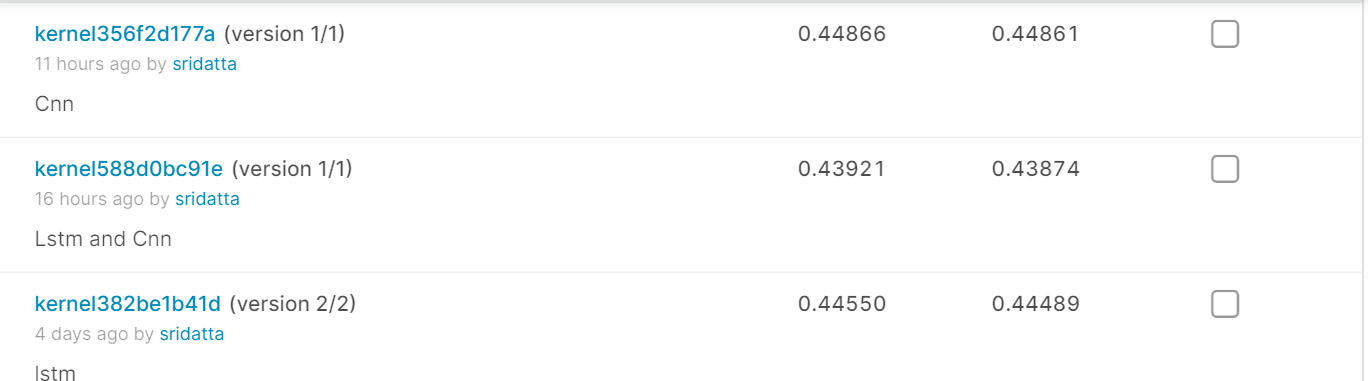

In [0]:
from PIL import Image
jpgfile = Image.open("/content/all_scores.PNG")
jpgfile

# **Implement CNN and LSTM:**

In [4]:
# Importing train data.
print("Importing Train Data...")
train = pd.read_table('/content/drive/My Drive/train.tsv')
print("Shape of Train data :",train.shape)
# Checking for NaN in the data.
print("Checking for any null values..")
print(train.isnull().any())
print("Performing Preprocessing and Feature engineering...")
# Removing Lower Prices which are less than 3.
train = train.drop(train[(train.price < 5.0)].index)
train.shape
# Getting Length of each text in name and item_description.
train['desc_len'] = train['item_description'].apply(lambda x: word_count(x))
train['name_len'] = train['name'].apply(lambda x: word_count(x))
train.head()
# Subdiving category.
train["subcat_0"] = cat_split("category_name",0)
train["subcat_1"] = cat_split("category_name",1)
train["subcat_2"] = cat_split("category_name",2)
# Filling All the NAN rows of brand name with text "missing"
brand_vocab = set(train['brand_name'].values) # Get all the brands.
train.brand_name.fillna(value = "missing", inplace = True)
#all_brands
missing = len(train.loc[train["brand_name"] == 'missing'])
#premissing
print(missing)
train['brand_name'] = train[['brand_name','name']].apply(finding_brand, axis = 1)
detected_brands = missing-len(train.loc[train['brand_name'] == 'missing'])
print(detected_brands)
train = fill_missing_values(train)
print(train.category_name[1])
train["target"] = np.log1p(train.price)
train["combined_text"] = train["item_description"] + " " + train["name"]

Importing Train Data...
Shape of Train data : (1482535, 8)
Checking for any null values..
train_id             False
name                 False
item_condition_id    False
category_name         True
brand_name            True
price                False
shipping             False
item_description      True
dtype: bool
Performing Preprocessing and Feature engineering...
607593
125239
Electronics/Computers & Tablets/Components & Parts


In [5]:
# Importing Test data.
print("Importing Test Data...")
test = pd.read_table('/content/drive/My Drive/test.tsv')
print("Shape of Train data :",test.shape)
# Checking for NaN in the data.
print("Checking for any null values..")
print(test.isnull().any())
print("Performing Preprocessing and Feature engineering...")
# Removing Lower Prices which are less than 3.
test.shape
# Getting Length of each text in name and item_description.
test['desc_len'] = test['item_description'].apply(lambda x: word_count(x))
test['name_len'] = test['name'].apply(lambda x: word_count(x))
test.head()
# Subdiving category.
test["subcat_0"] = cat_split_test("category_name",0)
test["subcat_1"] = cat_split_test("category_name",1)
test["subcat_2"] = cat_split_test("category_name",2)
# Filling All the NAN rows of brand name with text "missing"
brand_vocab = set(test['brand_name'].values) # Get all the brands.
test.brand_name.fillna(value = "missing", inplace = True)
#all_brands
missing = len(test.loc[test["brand_name"] == 'missing'])
#premissing
print(missing)
test['brand_name'] = test[['brand_name','name']].apply(finding_brand, axis = 1)
detected_brands = missing-len(test.loc[test['brand_name'] == 'missing'])
print(detected_brands)
test = fill_missing_values(test)
print(test.category_name[1])
test["combined_text"] = test["item_description"] + " " + test["name"]

Importing Test Data...
Shape of Train data : (693359, 7)
Checking for any null values..
test_id              False
name                 False
item_condition_id    False
category_name         True
brand_name            True
shipping             False
item_description     False
dtype: bool
Performing Preprocessing and Feature engineering...
295525
59695
Other/Office supplies/Shipping Supplies


In [0]:
# https://stackoverflow.com/a/56876351
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [0]:
# We Convert all the data columns in the form of strings.
train['brand_name'] = train['brand_name'].fillna('missing').astype(str)
test['brand_name'] = test['brand_name'].fillna('missing').astype(str)


label = LabelEncoderExt()
label.fit(np.hstack([train.brand_name, test.brand_name]))
train['brand_name'] = label.transform(train.brand_name)
test['brand_name'] = label.transform(test.brand_name)
del label 

In [0]:
# Encoding Categorical Features.
label = LabelEncoderExt()
label.fit(np.hstack([train.category_name, test.category_name])) # categories united 

train['category'] = label.transform(train.category_name)
test['category'] = label.transform(test.category_name)

label.fit(np.hstack([train.subcat_0, test.subcat_0])) # sub_cat0
train.subcat_0 = label.transform(train.subcat_0)
test.subcat_0 = label.transform(test.subcat_0)

label.fit(np.hstack([train.subcat_1, test.subcat_1])) # sub_cat_1
train.subcat_1 = label.transform(train.subcat_1)
test.subcat_1 = label.transform(test.subcat_1)

label.fit(np.hstack([train.subcat_2, test.subcat_2])) # sub_cat2
train.subcat_2 = label.transform(train.subcat_2)
test.subcat_2 = label.transform(test.subcat_2)
del label 

In [0]:
# Text to Sequence Data.
# Combining columns, item_description, name, category_name.
full_text = np.hstack([train.item_description.str.lower(), train.name.str.lower(), train.category_name.str.lower()]) 

# Tokenizing on combined columns.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_text)

train["seq_combined"] = tokenizer.texts_to_sequences(train.combined_text.str.lower())
test["seq_combined"] = tokenizer.texts_to_sequences(test.combined_text.str.lower())

train['seq_desc'] = tokenizer.texts_to_sequences(train.item_description.str.lower()) 
test['seq_desc'] = tokenizer.texts_to_sequences(test.item_description.str.lower()) 

train['seq_name'] = tokenizer.texts_to_sequences(train.name.str.lower()) 
test['seq_name'] = tokenizer.texts_to_sequences(test.name.str.lower()) 

In [0]:
# max length for Categorical Data.
#max_len_cat = np.max(train.category.max()) + 1 # category
max_len_combined = np.max([max(train.seq_combined.max()), max(test.seq_combined.max())]) + 1
max_len_brand =  np.max([train.brand_name.max(), test.brand_name.max()]) + 1   # brand # brand 
max_len_condition = np.max([max(train.item_condition_id), max(test.item_condition_id)]) + 1  # item_cond
max_len_desc = np.max([int(train.desc_len.max()), int(test.desc_len.max())]) + 1  # item_desc_len
max_len_name = np.max([int(train.name_len.max()), int(test.name_len.max())]) + 1 # name_len
max_len_sub0 = np.max([int(train.subcat_0.max()), int(train.subcat_0.max())])  + 1# Sub_0
max_len_sub1 = np.max([int(train.subcat_1.max()), int(train.subcat_1.max())]) + 1 # Sub_1
max_len_sub2 = np.max([train.subcat_2.max(), train.subcat_2.max()]) + 1  # Sub_2
# Defining max length for Padding Text Data.
name_padding = 10
description_padding = 70
combined_padding  =  70
max_len = np.max([np.max(train.seq_name.max()),np.max(train.seq_desc.max()),np.max(test.seq_name.max()),np.max(test.seq_desc.max())]) + 1

In [0]:
# Train and Test Split.
x_tr, x_te = train_test_split(train, random_state=123, train_size=0.99)
Y_train = x_tr.target.values.reshape(-1, 1)
Y_test = x_te.target.values.reshape(-1, 1)

In [0]:
# Padding Name :
x_train_padded = { 
"name" : pad_sequences(x_tr.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_tr.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_tr.brand_name),
"category" :np.array(x_tr.category),
"item_condition" : np.array(x_tr.item_condition_id),
"shipping" : np.array(x_tr[["shipping"]]),
"desc_len" : np.array(x_tr[["desc_len"]]),
"name_len" : np.array(x_tr[["name_len"]]),
"subcat_0" : np.array(x_tr.subcat_0),
"subcat_1"  : np.array(x_tr.subcat_1),
"subcat_2" : np.array(x_tr.subcat_2),
"combined_text" : pad_sequences(x_tr.seq_combined, maxlen= combined_padding)
} 

x_test_padded = {
"name" : pad_sequences(x_te.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(x_te.seq_desc, maxlen= description_padding),
"brand_name" : np.array(x_te.brand_name),
"category" : np.array(x_te.category),
"item_condition" : np.array(x_te.item_condition_id),
"shipping" : np.array(x_te[["shipping"]]),
"desc_len" : np.array(x_te[["desc_len"]]),
"name_len" : np.array(x_te[["name_len"]]),
"subcat_0" : np.array(x_te.subcat_0),
"subcat_1" : np.array(x_te.subcat_1),
"subcat_2" : np.array(x_te.subcat_2),
"combined_text" : pad_sequences(x_te.seq_combined, maxlen= combined_padding)
}


te_data = {
"name" : pad_sequences(test.seq_name, maxlen= name_padding),
"item_desc" : pad_sequences(test.seq_desc, maxlen= description_padding),
"brand_name" : np.array(test.brand_name),
"category" : np.array(test.category),
"item_condition" : np.array(test.item_condition_id),
"shipping" : np.array(test[["shipping"]]),
"desc_len" : np.array(test[["desc_len"]]),
"name_len" : np.array(test[["name_len"]]),
"subcat_0" : np.array(test.subcat_0),
"subcat_1" : np.array(test.subcat_1),
"subcat_2" : np.array(test.subcat_2),
"combined_text" : pad_sequences(test.seq_combined, maxlen= combined_padding)
}

In [0]:
x_tr = x_train_padded
x_te = x_test_padded
X_test = te_data

**MODEL:1 CNN, LSTM**

In [0]:
# Definign Inputs.
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name =Input(shape=[1], name="brand_name")

num_vars = Input(shape=[x_tr["shipping"].shape[1]], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(shape=[x_tr["name"].shape[1]], name="name") # 15 shape = [15]
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc") # 80 shape = [80]
combined_text = Input(shape=[x_tr["combined_text"].shape[1]], name="combined_text")

sub0_emb = Embedding(max_len_sub0, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2, 10)(subcat_2)

brand_emb = Embedding(max_len_brand, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition, 5)(item_condition)

name_emb = Embedding(max_len, 10)(name)
item_desc_emb = Embedding(max_len, 70)(item_desc)

desc_len_emb = Embedding(max_len_desc, 5)(desc_len)
name_len_emb = Embedding(max_len_name, 5)(name_len)
combined_len_emb  = Embedding(max_len_combined, 80)(combined_text)

# Defining Lstm Layer for combined Text Data.
gru_layer = GRU(64) (combined_len_emb)
lstm_layer = LSTM(16) (brand_emb)

convs1 = []
convs2 = []

for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

#flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

main_l = concatenate([lstm_layer, flat_2, flat_5, flat_6, flat_7,gru_layer, convs1, convs2,num_vars])

main_l = Dropout(0.1)(Dense(192,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))

# Set hyper parameters for the model.
BATCH_SIZE = 512 * 3
epochs = 2

output = Dense(1, activation="linear") (main_l)
    
model_1 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, combined_text,  subcat_0, subcat_1, subcat_2, num_vars ], output)

optimizer = optimizers.Adam(lr = 0.005 )
model_1.compile(loss = 'mse', optimizer = optimizer)

model_1.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               (None, 10)           0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 10, 10)       2554430     name[0][0]                       
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 70, 70)       17881010    item_desc[0][0]                  
____________________________________________________________________________________________

In [0]:
# Create model and fit it with training dataset.
model_1.fit(x_tr, Y_train, epochs= 2 , batch_size= 512 * 3, validation_data = (x_te, Y_test), verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1432350 samples, validate on 14469 samples
Epoch 1/2
1432350/1432350 [==============================] - 308s 215us/step - loss: 0.4426 - val_loss: 0.1814
Epoch 2/2
1432350/1432350 [==============================] - 306s 214us/step - loss: 0.1506 - val_loss: 0.1756


In [0]:
y_pred = model_2.predict(x_te, batch_size=512 * 3)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.4190950766502912


In [0]:
#CREATE PREDICTIONS
preds = model_2.predict(X_test, batch_size = 512*3)

test_pred = np.expm1(preds)

submission = pd.DataFrame(test[["test_id"]])
submission["price"] = test_pred

In [0]:
submission.head()

,test_id,price
0,0,8.729796
1,1,9.420729
2,2,60.822071
3,3,13.915297
4,4,8.166396


**Model 2: CNN, LSTM with Early Stopping (Patience = 3)**

In [14]:
# Definign Inputs.
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name =Input(shape=[1], name="brand_name")

num_vars = Input(shape=[x_tr["shipping"].shape[1]], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(shape=[x_tr["name"].shape[1]], name="name") # 15 shape = [15]
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc") # 80 shape = [80]
combined_text = Input(shape=[x_tr["combined_text"].shape[1]], name="combined_text")

sub0_emb = Embedding(max_len_sub0, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2, 10)(subcat_2)

brand_emb = Embedding(max_len_brand, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition, 5)(item_condition)

name_emb = Embedding(max_len, 10)(name)
item_desc_emb = Embedding(max_len, 70)(item_desc)

desc_len_emb = Embedding(max_len_desc, 5)(desc_len)
name_len_emb = Embedding(max_len_name, 5)(name_len)
combined_len_emb  = Embedding(max_len_combined, 80)(combined_text)

# Defining Lstm Layer for combined Text Data.
gru_layer = GRU(64) (combined_len_emb)
lstm_layer = LSTM(16) (brand_emb)

convs1 = []
convs2 = []

for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

#flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

main_l = concatenate([lstm_layer, flat_2, flat_5, flat_6, flat_7,gru_layer, convs1, convs2,num_vars])

main_l = Dropout(0.1)(Dense(192,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))

# Set hyper parameters for the model.
BATCH_SIZE = 512 * 3
epochs = 2

output = Dense(1, activation="linear") (main_l)
    
model_2 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, combined_text,  subcat_0, subcat_1, subcat_2, num_vars ], output)

optimizer = optimizers.Adam(lr = 0.005 )
model_2.compile(loss = 'mse', optimizer = optimizer)

model_2.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               (None, 10)           0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 10, 10)       2554430     name[0][0]                       
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 70, 70)       17881010    item_desc[0][0]                  
____________________________________________________________________________________________

In [0]:
# Create model and fit it with training dataset.
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",verbose=1, mode='min', patience = 3)
model_2.fit(x_tr, Y_train, epochs= 60 , batch_size= 512 * 3, validation_data = (x_te, Y_test), verbose=1, callbacks = [earlyStop])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1432350 samples, validate on 14469 samples
Epoch 1/60
1432350/1432350 [==============================] - 264s 184us/step - loss: 0.4421 - val_loss: 0.1803
Epoch 2/60
1432350/1432350 [==============================] - 261s 182us/step - loss: 0.1513 - val_loss: 0.1722
Epoch 3/60
1432350/1432350 [==============================] - 261s 182us/step - loss: 0.1194 - val_loss: 0.1733
Epoch 4/60
1432350/1432350 [==============================] - 257s 179us/step - loss: 0.0997 - val_loss: 0.1702
Epoch 5/60
1432350/1432350 [==============================] - 257s 179us/step - loss: 0.0862 - val_loss: 0.1739
Epoch 6/60
1432350/1432350 [==============================] - 259s 181us/step - loss: 0.0766 - val_loss: 0.1753
Epoch 7/60
1432350/1432350 [==============================] - 260s 182us/step - loss: 0.0692 - val_loss: 0.1819
Epoch 00007: early stopping


In [0]:
y_pred = model_2.predict(x_te, batch_size=512 * 3)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.426543858000284


**Model 3: CNN, LSTM, Early Stopping (Patience = 5)**

In [15]:
# Definign Inputs.
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name =Input(shape=[1], name="brand_name")

num_vars = Input(shape=[x_tr["shipping"].shape[1]], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(shape=[x_tr["name"].shape[1]], name="name") # 15 shape = [15]
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc") # 80 shape = [80]
combined_text = Input(shape=[x_tr["combined_text"].shape[1]], name="combined_text")

sub0_emb = Embedding(max_len_sub0, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2, 10)(subcat_2)

brand_emb = Embedding(max_len_brand, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition, 5)(item_condition)

name_emb = Embedding(max_len, 10)(name)
item_desc_emb = Embedding(max_len, 70)(item_desc)

desc_len_emb = Embedding(max_len_desc, 5)(desc_len)
name_len_emb = Embedding(max_len_name, 5)(name_len)
combined_len_emb  = Embedding(max_len_combined, 80)(combined_text)

# Defining Lstm Layer for combined Text Data.
gru_layer = GRU(64) (combined_len_emb)
lstm_layer = LSTM(16) (brand_emb)

convs1 = []
convs2 = []

for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

#flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

main_l = concatenate([lstm_layer, flat_2, flat_5, flat_6, flat_7,gru_layer, convs1, convs2,num_vars])

main_l = Dropout(0.1)(Dense(192,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))

# Set hyper parameters for the model.
BATCH_SIZE = 512 * 3
epochs = 2

output = Dense(1, activation="linear") (main_l)
    
model_3 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, combined_text,  subcat_0, subcat_1, subcat_2, num_vars ], output)

optimizer = optimizers.Adam(lr = 0.005 )
model_3.compile(loss = 'mse', optimizer = optimizer)

model_3.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               (None, 10)           0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 10, 10)       2554430     name[0][0]                       
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 70, 70)       17881010    item_desc[0][0]                  
____________________________________________________________________________________________

In [16]:
# Create model and fit it with training dataset.
from keras.callbacks import EarlyStopping
earlyStop=EarlyStopping(monitor="val_loss",verbose=1, mode='min', patience = 5)
model_3.fit(x_tr, Y_train, epochs= 60 , batch_size= 512 * 3, validation_data = (x_te, Y_test), verbose=1, callbacks = [earlyStop])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1432350 samples, validate on 14469 samples
Epoch 1/60
1432350/1432350 [==============================] - 260s 182us/step - loss: 0.4368 - val_loss: 0.1841
Epoch 2/60
1432350/1432350 [==============================] - 251s 175us/step - loss: 0.1519 - val_loss: 0.1774
Epoch 3/60
1432350/1432350 [==============================] - 250s 175us/step - loss: 0.1236 - val_loss: 0.1757
Epoch 4/60
1432350/1432350 [==============================] - 250s 174us/step - loss: 0.1063 - val_loss: 0.1790
Epoch 5/60
1432350/1432350 [==============================] - 248s 173us/step - loss: 0.0944 - val_loss: 0.1740
Epoch 6/60
1432350/1432350 [==============================] - 247s 173us/step - loss: 0.0854 - val_loss: 0.1746
Epoch 7/60
1432350/1432350 [==============================] - 248s 173us/step - loss: 0.0782 - val_loss: 0.1772
Epoch 8/60
1432350/1432350 [==============================] - 249s 174us/step - loss: 0.0721 - val_loss: 0.1757
Epoch 9/60
1432350/1432350 [========================

In [17]:
y_pred = model_3.predict(x_te, batch_size=512 * 3)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.4223680902635731


**Model 4: CNN, LSTM Running for 20 Epochs**

In [18]:
# Definign Inputs.
subcat_0 = Input(shape=[1], name="subcat_0")
subcat_1 = Input(shape=[1], name="subcat_1")
subcat_2 = Input(shape=[1], name="subcat_2")
desc_len = Input(shape=[1], name="desc_len")
name_len = Input(shape=[1], name="name_len")

brand_name =Input(shape=[1], name="brand_name")

num_vars = Input(shape=[x_tr["shipping"].shape[1]], name="shipping")

item_condition = Input(shape=[1], name="item_condition")

name = Input(shape=[x_tr["name"].shape[1]], name="name") # 15 shape = [15]
item_desc = Input(shape=[x_tr["item_desc"].shape[1]], name="item_desc") # 80 shape = [80]
combined_text = Input(shape=[x_tr["combined_text"].shape[1]], name="combined_text")

sub0_emb = Embedding(max_len_sub0, 10)(subcat_0)
sub1_emb = Embedding(max_len_sub1, 10)(subcat_1)
sub2_emb = Embedding(max_len_sub2, 10)(subcat_2)

brand_emb = Embedding(max_len_brand, 10)(brand_name)

item_cond_emb = Embedding(max_len_condition, 5)(item_condition)

name_emb = Embedding(max_len, 10)(name)
item_desc_emb = Embedding(max_len, 70)(item_desc)

desc_len_emb = Embedding(max_len_desc, 5)(desc_len)
name_len_emb = Embedding(max_len_name, 5)(name_len)
combined_len_emb  = Embedding(max_len_combined, 80)(combined_text)

# Defining Lstm Layer for combined Text Data.
gru_layer = GRU(64) (combined_len_emb)
lstm_layer = LSTM(16) (brand_emb)

convs1 = []
convs2 = []

for filter_length in [1,2]:
  cnn_layer1 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (name_emb)
  cnn_layer2 = Conv1D(filters=50, kernel_size=filter_length, padding='same', activation='relu', strides=1) (item_desc_emb)
  maxpool1 = GlobalMaxPooling1D() (cnn_layer1)
  maxpool2 = GlobalMaxPooling1D() (cnn_layer2)
  convs1.append(maxpool1)
  convs2.append(maxpool2)

convs1 = concatenate(convs1)
convs2 = concatenate(convs2)

#flat_1 = Flatten() (brand_emb)
flat_2 = Flatten() (item_cond_emb)
flat_5 = Flatten() (sub0_emb)
flat_6 = Flatten() (sub1_emb)
flat_7 = Flatten() (sub2_emb)

main_l = concatenate([lstm_layer, flat_2, flat_5, flat_6, flat_7,gru_layer, convs1, convs2,num_vars])

main_l = Dropout(0.1)(Dense(192,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(128,kernel_initializer='normal',activation='relu') (main_l))
main_l = Dropout(0.1)(Dense(64,kernel_initializer='normal',activation='relu') (main_l))
main_l = BatchNormalization()(Dense(32,kernel_initializer='normal',activation='relu') (main_l))

# Set hyper parameters for the model.
BATCH_SIZE = 512 * 3
epochs = 2

output = Dense(1, activation="linear") (main_l)
    
model_4 = Model([name, item_desc, brand_name , desc_len,name_len, item_condition, combined_text,  subcat_0, subcat_1, subcat_2, num_vars ], output)

optimizer = optimizers.Adam(lr = 0.005 )
model_4.compile(loss = 'mse', optimizer = optimizer)

model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
name (InputLayer)               (None, 10)           0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 70)           0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 10, 10)       2554430     name[0][0]                       
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 70, 70)       17881010    item_desc[0][0]                  
____________________________________________________________________________________________

In [19]:
# Create model and fit it with training dataset.
model_4.fit(x_tr, Y_train, epochs= 20 , batch_size= 512 * 3, validation_data = (x_te, Y_test), verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1432350 samples, validate on 14469 samples
Epoch 1/20
1432350/1432350 [==============================] - 252s 176us/step - loss: 0.4582 - val_loss: 0.1889
Epoch 2/20
1432350/1432350 [==============================] - 252s 176us/step - loss: 0.1579 - val_loss: 0.1791
Epoch 3/20
1432350/1432350 [==============================] - 250s 175us/step - loss: 0.1287 - val_loss: 0.1744
Epoch 4/20
1432350/1432350 [==============================] - 248s 173us/step - loss: 0.1108 - val_loss: 0.1752
Epoch 5/20
1432350/1432350 [==============================] - 248s 173us/step - loss: 0.0983 - val_loss: 0.1745
Epoch 6/20
1432350/1432350 [==============================] - 251s 175us/step - loss: 0.0889 - val_loss: 0.1831
Epoch 7/20
1432350/1432350 [==============================] - 250s 174us/step - loss: 0.0814 - val_loss: 0.1736
Epoch 8/20
1432350/1432350 [==============================] - 248s 173us/step - loss: 0.0756 - val_loss: 0.1753
Epoch 9/20
1432350/1432350 [========================

In [20]:
y_pred = model_4.predict(x_te, batch_size=512 * 3)
print(" RMSLE error:", rmsle(Y_test, y_pred))

 RMSLE error: 0.4344567272750884


## Running for the model with early stopping with patience = 5 and also with 20 epochs didn't imporve the Rmsle score.

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Rmsle Error"]
x.add_row(["LSTM", 0.42])
x.add_row(["CNN'S", 0.42])
x.add_row(["LSTM,CNN'S with Test", 0.41])
x.add_row(["LSTM, CNN Early Stop", 0.42])

print(x)

+----------------------+-------------+
|        Model         | Rmsle Error |
+----------------------+-------------+
|         LSTM         |     0.42    |
|        CNN'S         |     0.42    |
| LSTM,CNN'S with Test |     0.41    |
| LSTM, CNN Early Stop |     0.42    |
+----------------------+-------------+


# **Kaggle ScreenShots**

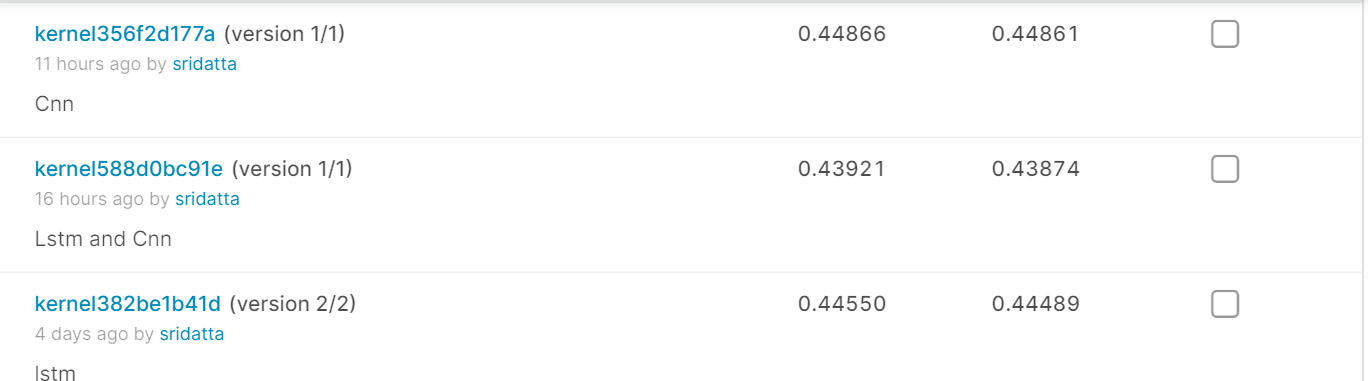

In [0]:
from PIL import Image
jpgfile = Image.open("/content/all_scores.PNG")
jpgfile

**CNN WITH LSTM**

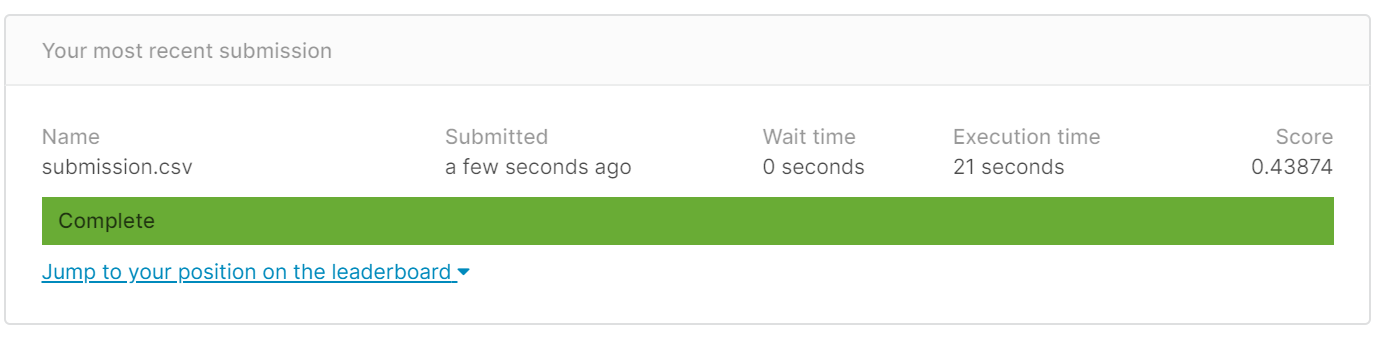

In [0]:
from PIL import Image
jpgfile = Image.open("/content/cnnlstm.PNG")
jpgfile


**Cnn combined with Lstm Improved score from 0.44 to 0.43**

**CNN, LSTM Implemting :Early Stopping**

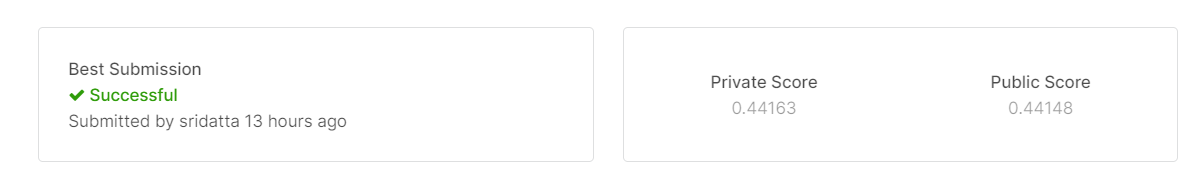

In [0]:
# CNN, LSTM with Early Stopping.
from PIL import Image
jpgfile = Image.open("/content/lstm_cnn_early_stop.PNG")
jpgfile

In [0]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Rmsle Error"]
x.add_row(["SVR", 0.47])
x.add_row(["Decision Tree Reg", 0.56])
x.add_row(["SGD Reg", 0.47])
x.add_row(["Ridge Reg", 0.47])
x.add_row(["Ridge Reg Cv", 0.44])
x.add_row(["Ensemble : Voting Reg", 0.44])
x.add_row(["Ensemble : Stacking Reg", 0.52])
x.add_row(["2x LSTM", 0.42])
x.add_row(["2x CNN", 0.42])
x.add_row(["1x LSTM 2x CNN", 0.41])
print(x)

+-------------------------+-------------+
|          Model          | Rmsle Error |
+-------------------------+-------------+
|           SVR           |     0.47    |
|    Decision Tree Reg    |     0.56    |
|         SGD Reg         |     0.47    |
|        Ridge Reg        |     0.47    |
|       Ridge Reg Cv      |     0.44    |
|  Ensemble : Voting Reg  |     0.44    |
| Ensemble : Stacking Reg |     0.52    |
|         2x LSTM         |     0.42    |
|          2x CNN         |     0.42    |
|      1x LSTM 2x CNN     |     0.41    |
+-------------------------+-------------+


# **Observation:**

**On Implementing Early Stopping the Model Didn't improve any better.** <br>**Running the model with early stopping with patience = 5 and also with 20 epochs didn't imporve the Rmsle score.**<br>
**With 20 epochs the RMSLE score is 0.43 and with Early Stopping patience = 5, Rmsle = 0.42**
